## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import tools as tools
# from tools import procesar_precios_bonos


# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### Import the csv files with the data while indexing first column as date

##########################################################################################
curvaESTR = pd.read_csv('C:\\Users\\javie\\OneDrive\\Finanzas Locales Javier\\SICAV\\00-NUEVO ONE DRIVE SH CAPITAL INVESTMENTS\\13. Python\\5. Python Scripts\\.vscode\\MIAX Master\\Modulo 2 - Practica\\data\\curvaESTR.csv', sep=';', index_col=0, parse_dates=True)
##########################################################################################
precios_historicos_universo = pd.read_csv('C:\\Users\\javie\\OneDrive\\Finanzas Locales Javier\\SICAV\\00-NUEVO ONE DRIVE SH CAPITAL INVESTMENTS\\13. Python\\5. Python Scripts\\.vscode\\MIAX Master\\Modulo 2 - Practica\\data\\precios_historicos_universo.csv', sep=';')
## Rename first column to Date
precios_historicos_universo = precios_historicos_universo.rename(columns={'Unnamed: 0': 'Date'})
### Set Date as index
precios_historicos_universo = precios_historicos_universo.set_index('Date')
### Transpose the DataFrame to have timeseries in rows and assets in columns
precios_historicos_universo = precios_historicos_universo.T
##########################################################################################
precios_historicos_varios = pd.read_csv('C:\\Users\\javie\\OneDrive\\Finanzas Locales Javier\\SICAV\\00-NUEVO ONE DRIVE SH CAPITAL INVESTMENTS\\13. Python\\5. Python Scripts\\.vscode\\MIAX Master\\Modulo 2 - Practica\\data\\precios_historicos_varios.csv', sep=';', index_col=0, parse_dates=True)
##########################################################################################
universo = pd.read_csv('C:\\Users\\javie\\OneDrive\\Finanzas Locales Javier\\SICAV\\00-NUEVO ONE DRIVE SH CAPITAL INVESTMENTS\\13. Python\\5. Python Scripts\\.vscode\\MIAX Master\\Modulo 2 - Practica\\data\\universo.csv', sep=';', index_col=0, parse_dates=True)

C:\Users\javie\AppData\Local\Temp\ipykernel_42344\4083844619.py:17: DtypeWarning: Columns (2,3,4,5,6,9,10,11,12,13,16,17,18,19,20,23,24,25,26,27,30,31,32,33,34,37,38,39,40,41,44,45,46,47,48,51,52,53,54,55,58,59,60,61,62,65,66,67,68,75,89,90,185,219,240,248,275,319,331,415,454,458,473,563,564,565,571,572,573,576,577,578,580,583,604,695) have mixed types. Specify dtype option on import or set low_memory=False.
  precios_historicos_universo = pd.read_csv('C:\\Users\\javie\\OneDrive\\Finanzas Locales Javier\\SICAV\\00-NUEVO ONE DRIVE SH CAPITAL INVESTMENTS\\13. Python\\5. Python Scripts\\.vscode\\MIAX Master\\Modulo 2 - Practica\\data\\precios_historicos_universo.csv', sep=';')
C:\Users\javie\AppData\Local\Temp\ipykernel_42344\4083844619.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  universo = pd.read_csv('C:\\Users\\javie\\OneDrive\\Finanzas Lo

##### <font color=#CC6600>Precios bonos universo</font>

In [2]:
### --- PREPROCESAMIENTO DE DATOS ---


# --- EJECUCIÓN ---
precios_clean, reporte = tools.procesar_precios_bonos(precios_historicos_universo, universo)

# --- INFORME DE RESULTADOS ---
print("-" * 50)
print("RESUMEN DEL PROCESO DE LIMPIEZA")
print("-" * 50)
print(f"1. Estructura Temporal:")
print(f"   - Días originales en la serie: {reporte['Filas Originales']}")
print(f"   - Días hábiles finales:        {reporte['Filas Finales (Trading Days)']}")
print(f"   - Días eliminados (Sáb/Dom):   {reporte['Días Eliminados']}")
print("-" * 50)
print(f"2. Calidad del Dato (Sanitización):")
# Ahora la clave coincide exactamente
print(f"   - Se han eliminado {reporte['Celdas Zombie Corregidas']} precios que existían después del vencimiento.")
print(f"   - Se han mantenido los precios mediante 'forward-fill' durante la vida activa del bono.")
print("-" * 50)
print(f"3. Resultado Final:")
print(f"   - Dimensiones del DataFrame limpio: {reporte['Forma Final']}")
print("-" * 50)

# Verificación rápida
print("\nMuestra de datos limpios (Cola):")
print(precios_clean.iloc[-5:, :5])

1. Iniciando conversión de tipos...
2. Filtrando días no laborables y festivos...
3. Aplicando Forward Fill con control de Vencimientos...
--------------------------------------------------
RESUMEN DEL PROCESO DE LIMPIEZA
--------------------------------------------------
1. Estructura Temporal:
   - Días originales en la serie: 732
   - Días hábiles finales:        523
   - Días eliminados (Sáb/Dom):   209
--------------------------------------------------
2. Calidad del Dato (Sanitización):
   - Se han eliminado 0 precios que existían después del vencimiento.
   - Se han mantenido los precios mediante 'forward-fill' durante la vida activa del bono.
--------------------------------------------------
3. Resultado Final:
   - Dimensiones del DataFrame limpio: (523, 2255)
--------------------------------------------------

Muestra de datos limpios (Cola):
Date        XS0161488498 Corp  FR0000471930 Corp  XS0162513211 Corp  \
2025-09-25           127.4310           130.8840            115

c:\MIAX_Python\Modulo2\MIAX---Modulo-2\src\tools.py:146: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo['Maturity'] = pd.to_datetime(universo['Maturity'], errors='coerce')


##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

In [3]:


# ==============================================================================
# 3. EJECUCIÓN DEL FLUJO DE TRABAJO (MASTER)
# ==============================================================================

# 1. Procesar Bonos
df_bonos_clean = tools.procesar_bonos(precios_historicos_universo, universo)

# 2. Procesar Mercado (pre-alineado)
df_mercado_temp = tools.procesar_mercado(precios_historicos_varios, df_bonos_clean)

# 3. Alineación Final Estricta (Intersección)
common_dates = df_bonos_clean.index.intersection(df_mercado_temp.index)
df_bonos_final = df_bonos_clean.loc[common_dates]
df_mercado_final = df_mercado_temp.loc[common_dates]

# 4. Procesar Curva ESTR (Independiente)
df_curva_final = tools.procesar_curva_estr(curvaESTR)

# # ==============================================================================
# # 4. VALIDACIÓN VISUAL
# # ==============================================================================
# print("\n--- VALIDACIÓN FINAL ---")
# print(f"Bonos Finales: {df_bonos_final.shape}")
# print(f"Mercado Final: {df_mercado_final.shape}")
# print(f"Curva Final:   {df_curva_final.shape}")

# # Gráfico de control para la curva (Zoom inicio)
# plt.figure(figsize=(10, 4))
# plt.plot(df_curva_final.index[:20], df_curva_final['Zero Rate'][:20], marker='.', color='cyan')
# plt.title('Control de Calidad: Inicio de la Curva ESTR (Backfill)')
# plt.grid(True, alpha=0.3)
# plt.show()

--- [1/3] Procesando Precios de Bonos ---
   -> Iniciando limpieza base para: Bonos Históricos...
      Dimensión tras limpieza base: (523, 2255)
      Aplicando máscara de vencimientos...
      Datos 'Zombie' eliminados: 0
--- [2/3] Procesando Variables de Mercado ---
   -> Iniciando limpieza base para: Variables de Mercado...
      Dimensión tras limpieza base: (514, 6)
      Alineando fechas con el DataFrame de Bonos...
--- [3/3] Procesando Curva ESTR (Calendario Completo) ---
      Curva expandida de 33 nodos a 18265 días naturales.


c:\MIAX_Python\Modulo2\MIAX---Modulo-2\src\tools.py:269: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_universo['Maturity'] = pd.to_datetime(df_universo['Maturity'], errors='coerce')


In [4]:
df_mercado_final

,ITRX EUR CDSI GEN 5Y Corp,ITRX XOVER CDSI GEN 5Y Corp,DU1 Comdty,OE1 Comdty,RX1 Comdty,RECMTREU Index
2023-10-02,82.44325,439.1052,104.930,115.43,127.75,149.0285
2023-10-03,86.04738,455.2537,104.965,115.33,127.28,148.8003
2023-10-04,85.58153,453.8545,104.990,115.35,127.37,148.5200
2023-10-05,87.82574,461.1187,105.095,115.73,128.07,148.8967
2023-10-06,85.57082,453.6750,105.105,115.72,127.94,148.7697
...,...,...,...,...,...,...
2025-09-25,56.82300,268.1836,106.940,117.53,128.00,169.2455
2025-09-26,56.39975,265.4822,106.960,117.65,128.26,169.3753
2025-09-29,55.99791,262.7219,106.980,117.79,128.60,169.6040
2025-09-30,55.98538,262.2661,106.980,117.81,128.57,169.6283


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [5]:
# universo.columns
# df_bonos_final
# df_mercado_final
# df_curva_final

--- EJECUCIÓN DEL ANÁLISIS ---
Nombres de columnas de precios limpios (Ejemplo): XS0161488498
Índice del universo (Ejemplo): XS0161488498

✅ ÉXITO: Se han encontrado 2255 bonos comunes para valorar.
-> Ejecutando motor de valoración...
-> Cruzando con precios de mercado...

RESULTADOS FINALES DE VALORACIÓN
              Precio Limpio  Precio Mercado  Diferencia  Error
XS0161488498     133.757847        127.8353    5.922547    NaN
FR0000471930     137.971025        131.3195    6.651525    NaN
XS0162513211     122.217546        115.7800    6.437546    NaN
XS0162869076     123.056925        116.3000    6.756925    NaN
FR0010014845     125.363091        112.3887   12.974391    NaN
FR0010033381     126.706682        119.7020    7.004682    NaN
XS0229567440     113.863989        105.4562    8.407789    NaN
XS0300113254     104.616377        104.0970    0.519377    NaN
XS0350890470     135.470763        124.7700   10.700763    NaN
XS0553728709     110.568511        108.6433    1.925211    NaN

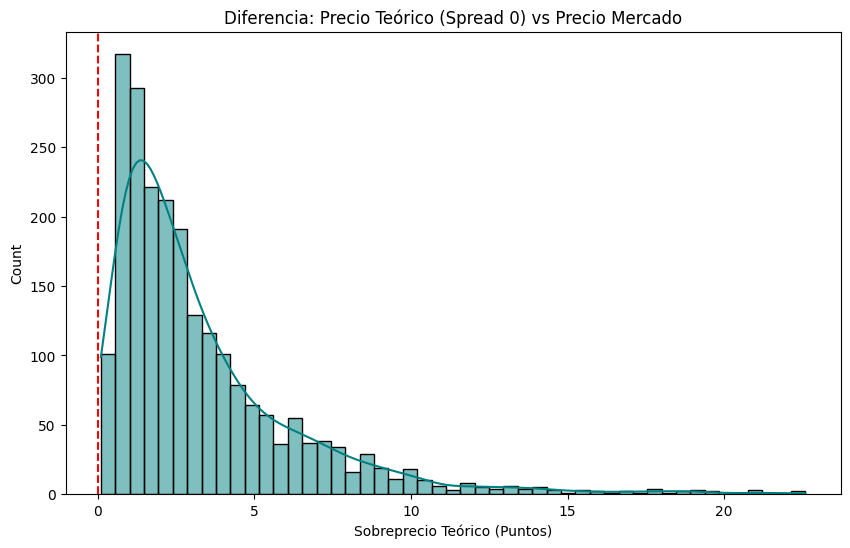

In [6]:
# ==============================================================================
# EJECUCIÓN DEL ANÁLISIS (CON CORRECCIÓN DE NOMBRES)
# ==============================================================================

print("--- EJECUCIÓN DEL ANÁLISIS ---")

# 0. LIMPIEZA DE IDENTIFICADORES (CRÍTICO)
# Quitamos el sufijo " Corp" de las columnas de precios para que coincidan con el ISIN
# Ejemplo: "XS0161488498 Corp" -> "XS0161488498"
df_bonos_final.columns = df_bonos_final.columns.str.replace(' Corp', '', regex=False).str.strip()

print(f"Nombres de columnas de precios limpios (Ejemplo): {df_bonos_final.columns[0]}")
print(f"Índice del universo (Ejemplo): {universo.index[0]}")

# 1. PREPARACIÓN DEL UNIVERSO
# Como ya confirmaste que el índice es el ISIN, usamos el índice directamente.
universo_valoracion = universo.copy()

# 2. FILTRADO (INTERSECCIÓN)
ids_precios = df_bonos_final.columns
ids_universo = universo_valoracion.index

# Ahora sí deberían coincidir
ids_comunes = ids_precios.intersection(ids_universo)

if len(ids_comunes) == 0:
    print("\n❌ ERROR CRÍTICO: Siguen sin coincidir. Revisa los ejemplos impresos arriba.")
else:
    print(f"\n✅ ÉXITO: Se han encontrado {len(ids_comunes)} bonos comunes para valorar.")
    
    # Recortamos el universo
    subset_universo = universo_valoracion.loc[ids_comunes].copy()

    # 3. VALORACIÓN VECTORIZADA
    print("-> Ejecutando motor de valoración...")
    
    df_valoraciones = subset_universo.apply(
        lambda row: tools.valorar_bono_pandas(
            row, 
            df_curva_final, 
            spread_bps=0, 
            fecha_val=pd.Timestamp('2025-10-01')
        ), 
        axis=1
    )

    # 4. CHEQUEO DE RESULTADOS
    if 'Precio Limpio' not in df_valoraciones.columns:
        print("❌ ERROR: DataFrame vacío tras valoración.")
    else:
        # 5. CRUCE CON DATOS DE MERCADO
        print("-> Cruzando con precios de mercado...")
        precios_mercado_ref = df_bonos_final.loc['2025-10-01', ids_comunes]
        df_valoraciones['Precio Mercado'] = precios_mercado_ref
        
        # 6. CÁLCULO DE DIFERENCIAS
        df_valoraciones['Diferencia'] = df_valoraciones['Precio Limpio'] - df_valoraciones['Precio Mercado']

        # --- VISUALIZACIÓN ---
        print("\n" + "="*50)
        print("RESULTADOS FINALES DE VALORACIÓN")
        print("="*50)
        
        cols_finales = ['Precio Limpio', 'Precio Mercado', 'Diferencia', 'Error']
        print(df_valoraciones[cols_finales].head(10))
        
        print("\nEstadísticas de la Diferencia (Spread=0):")
        # Filtramos errores para la estadística
        diffs_validas = df_valoraciones['Diferencia'].dropna()
        print(diffs_validas.describe())
        
        # Histograma de discrepancias
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(10, 6))
        sns.histplot(diffs_validas, kde=True, color='teal')
        plt.title('Diferencia: Precio Teórico (Spread 0) vs Precio Mercado')
        plt.xlabel('Sobreprecio Teórico (Puntos)')
        plt.axvline(0, color='red', linestyle='--')
        plt.show()

El diferencial es positivo para todos los bonos: estamos sobreestimando el precio del bono.

El principal factor es el spread 0 de crédito que estamos aplicando: estamos valorando el bono como si hubiese que descontarlo con el risk-free rate. Sin embargo, habría que descontarlo al risk-free rate + spread de riesgo crediticio de cada uno de los bonos.

Otro componente a tener en cuenta es que estamos valorando en 0 la opcionalidad del bono. Al asumir que el bono será calleado en el Next Call Date, estamos convirtiendo un bono de largo plazo en uno bullet.

 En el caso de los bonos callable, estamos asumiendo que el bono será calleado en la primera fecha de call posible. En este sentido, estamos asumiendo que el bono tiene que converger a su valor en par en un espacio temporal determinado. Dependiendo de cuándo se emitiese el bono, y de cómo han evolcionado los tipos de interés, actualmente etará cotizando a una prima o descuento sobre par. Esto hace que, por el hecho de tener que converger a un mayor corto plazo a su valor par, en algunos casos estaremos sobreestimando y en otros subestimando el valor del bono por este efecto.
Si cotiza con descuento  (< 100) lo estaremos sobrevalorando, y viceversa.

En el caso de los bonos perpetuos, con la asunción de Next Call Date, estamos cambiando un bono de muy larga duración por una de duración mucho más corta. En este caso, de nuevo, al converger mucho antes a su valor en par, por lo que estamos sobreestimando (si cotiza a descuento) o infravalorando (si cotiza con prima) ENORMEMENTE.

Para los bonos con cupón flotante, depende de la forma de la curva. Estamos asumiendo que el bono paga el mismo cupón a lo largo de toda la vida del bono. Si la curva está invertida (short rates > long rates), estamos sobrevalorando el bono (ya que asumimos que nos va a pagar cupones más altos de lo que espera el mercado). Si la estructura es normal, estamos infravalorando el bono (ya que asumimos que los cupones serán igual de bajos ahora que más adelante).





### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

--- Preparando datos ---
Total bonos: 2255
--- Iniciando Cálculo de Spreads (Modo Debug) ---
Éxito: 2255/2255 (100.0%)


C:\Users\javie\AppData\Local\Temp\ipykernel_42344\4034621780.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Rating', y='Calculated Spread (bps)', order=existentes, palette='RdYlGn_r')


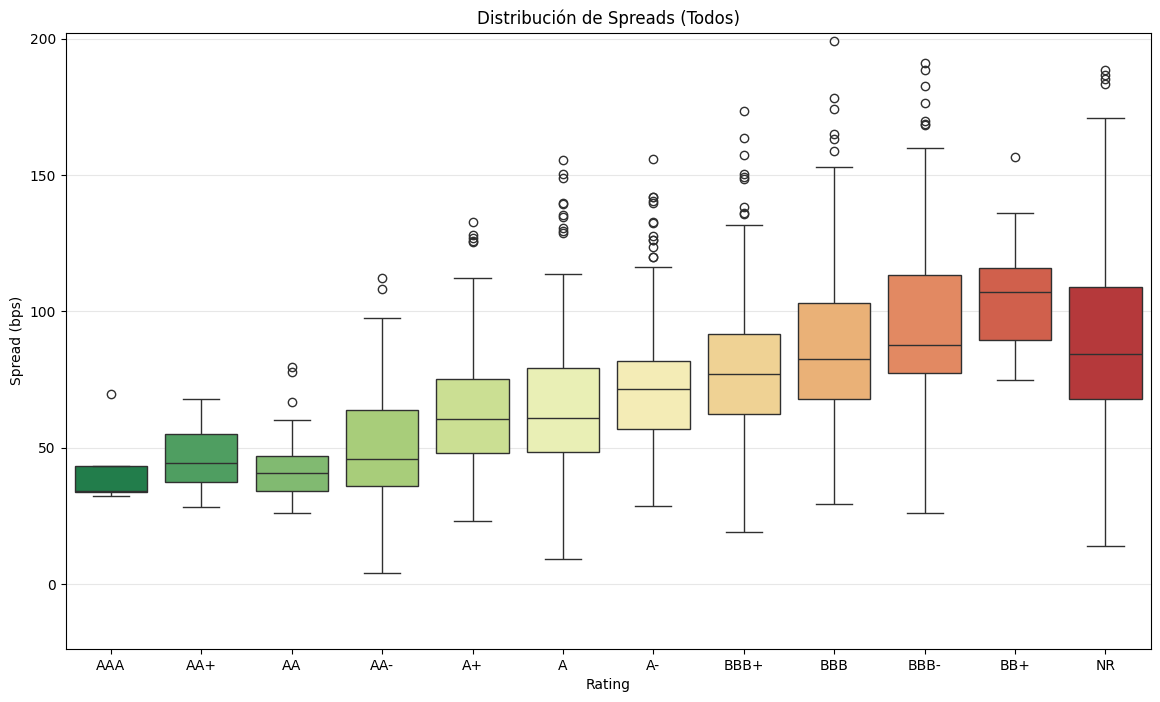


--- Filtrando Bonos Puros ---
Bonos Puros: 615


C:\Users\javie\AppData\Local\Temp\ipykernel_42344\4034621780.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Rating', y='Calculated Spread (bps)', order=existentes, palette='RdYlGn_r')


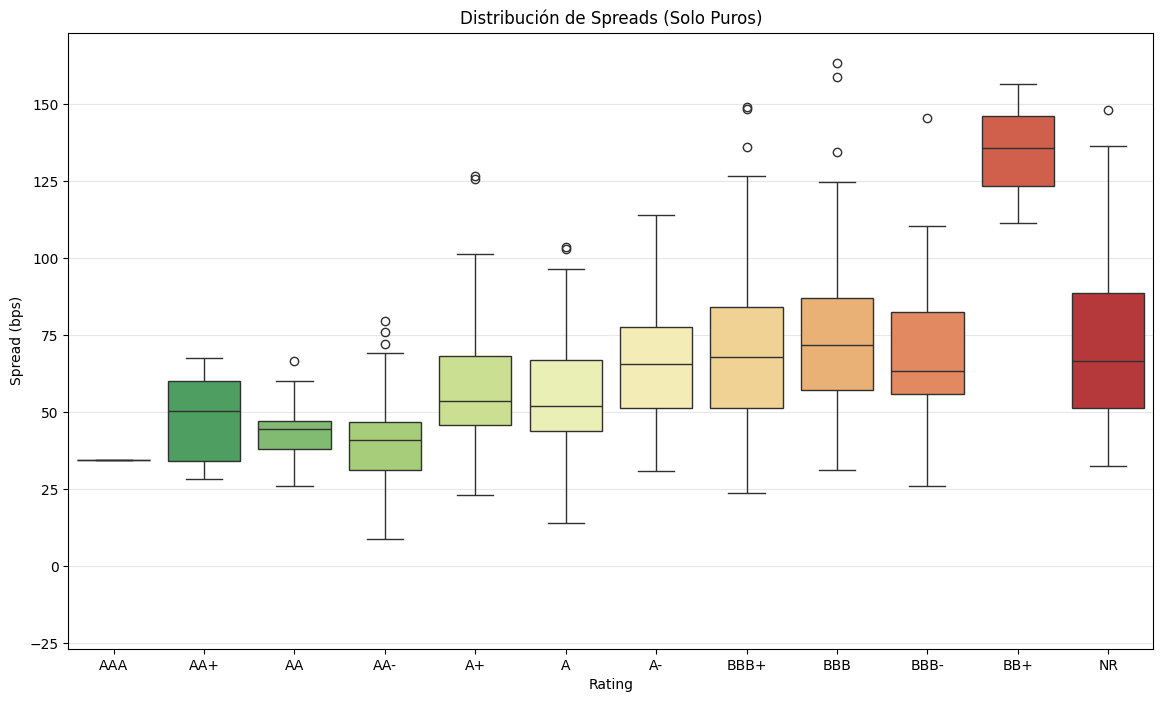

In [7]:
from scipy import optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. DEFINICIÓN DE FUNCIONES (TODO EN EL MISMO BLOQUE PARA EVITAR ERRORES)
# ==============================================================================

# A) FUNCIÓN DE VALORACIÓN (La versión robusta que definimos antes)
def valorar_bono_pandas(row, df_curva, spread_bps=0, fecha_val=pd.Timestamp('2025-10-01')):
    salida_error = pd.Series({'Precio Limpio': np.nan, 'Error': None})
    try:
        # Limpieza rápida de tipos
        nominal = 100.0
        spread = spread_bps / 10000.0
        try: val_cupon = float(row['Coupon'])
        except: val_cupon = 0.0
        coupon_rate = val_cupon / 100.0
        
        freq_map = {'1': 1, '2': 2, '4': 4, 1: 1, 2: 2, 4: 4}
        freq = freq_map.get(row['Coupon Frequency'], 1)
        
        # Fechas
        maturity = pd.to_datetime(row['Maturity'], dayfirst=True, errors='coerce')
        next_call = pd.to_datetime(row['Next Call Date'], dayfirst=True, errors='coerce')
        val_callable = row['Callable']
        es_callable = (val_callable == 'Y') or (val_callable == True)
        
        fecha_fin = maturity
        if es_callable and pd.notna(next_call): fecha_fin = next_call
        elif pd.isna(maturity) and pd.notna(next_call): fecha_fin = next_call
            
        if pd.isna(fecha_fin) or fecha_fin <= fecha_val:
            salida_error['Error'] = 'Vencido'
            return salida_error

        # Flujos
        flujos = []
        fecha_cursor = fecha_fin
        while fecha_cursor > fecha_val:
            flujos.append(fecha_cursor)
            meses_restar = int(12 / freq)
            fecha_cursor = fecha_cursor - pd.DateOffset(months=meses_restar)
        flujos = sorted(flujos)
        
        if not flujos: return salida_error # Caso raro

        # Pricing
        fecha_inicio_cupon = fecha_cursor
        dias_devengados = (fecha_val - fecha_inicio_cupon).days
        cupon_anual_dinero = nominal * coupon_rate
        cup_corrido = cupon_anual_dinero * (dias_devengados / 365.0)
        
        vp_sucio = 0
        for fecha_pago in flujos:
            t_years = (fecha_pago - fecha_val).days / 365.0
            try:
                df_risk_free = df_curva.loc[fecha_pago, 'Discount']
            except KeyError:
                df_risk_free = df_curva['Discount'].iloc[-1]
            
            df_total = df_risk_free * np.exp(-spread * t_years)
            pago = (cupon_anual_dinero / freq)
            if fecha_pago == fecha_fin: pago += nominal
            vp_sucio += pago * df_total
            
        return pd.Series({'Precio Limpio': vp_sucio - cup_corrido, 'Error': None})

    except Exception as e:
        salida_error['Error'] = str(e)
        return salida_error

# B) FUNCIONES DEL SOLVER (OPTIMIZADOR)
def objetivo_precio_wrapper(spread_bps, row, df_curva, precio_target, fecha_val):
    # Llamamos a la función local, no a tools.
    resultado = valorar_bono_pandas(row, df_curva, spread_bps=spread_bps, fecha_val=fecha_val)
    p_limpio = resultado.get('Precio Limpio', np.nan)
    if pd.isna(p_limpio): raise ValueError("Valoración NaN")
    return p_limpio - precio_target

def calcular_z_spread_debug(row, df_curva, precio_mercado, fecha_val):
    if pd.isna(precio_mercado) or precio_mercado <= 1: return np.nan
    
    # Wrapper para pasar argumentos fijos
    func = objetivo_precio_wrapper
    args = (row, df_curva, precio_mercado, fecha_val)
    
    try:
        # Búsqueda amplia
        return optimize.brentq(func, -5000, 25000, args=args, xtol=1e-1)
    except Exception as e:
        # --- DEBUGGING: Imprimir error solo la primera vez para no saturar ---
        if not hasattr(calcular_z_spread_debug, "error_count"): calcular_z_spread_debug.error_count = 0
        if calcular_z_spread_debug.error_count < 5:
            print(f"⚠️ Error en bono {row.name}: {str(e)}")
            calcular_z_spread_debug.error_count += 1
        return np.nan

# ==============================================================================
# 2. PREPARACIÓN Y EJECUCIÓN
# ==============================================================================

print("--- Preparando datos ---")
# Reconstruimos df_spreads asegurando integridad
df_spreads = df_valoraciones[['Precio Mercado']].copy()
cols_universo = ['Rating', 'Callable', 'Coupon Type', 'Maturity', 'Coupon', 'Coupon Frequency', 'Next Call Date']
df_spreads = df_spreads.join(subset_universo[cols_universo])

print(f"Total bonos: {len(df_spreads)}")

print("--- Iniciando Cálculo de Spreads (Modo Debug) ---")

# Usamos la función local con debug
df_spreads['Calculated Spread (bps)'] = df_spreads.apply(
    lambda row: calcular_z_spread_debug(
        row, 
        df_curva_final, 
        row['Precio Mercado'], 
        pd.Timestamp('2025-10-01')
    ), 
    axis=1
)

n_exito = df_spreads['Calculated Spread (bps)'].notna().sum()
print(f"Éxito: {n_exito}/{len(df_spreads)} ({(n_exito/len(df_spreads))*100:.1f}%)")

# ==============================================================================
# 3. VISUALIZACIÓN
# ==============================================================================

def plot_spreads_seguro(df_in, titulo):
    data = df_in.dropna(subset=['Calculated Spread (bps)', 'Rating']).copy()
    if data.empty:
        print(f"⚠️ {titulo}: No hay datos válidos para graficar.")
        return

    orden = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'NR']
    existentes = [x for x in orden if x in data['Rating'].unique()]
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=data, x='Rating', y='Calculated Spread (bps)', order=existentes, palette='RdYlGn_r')
    plt.title(titulo)
    plt.ylabel('Spread (bps)')
    plt.grid(axis='y', alpha=0.3)
    
    # Límites seguros
    q01 = data['Calculated Spread (bps)'].quantile(0.01)
    q99 = data['Calculated Spread (bps)'].quantile(0.99)
    # Evitar error si q99 es NaN (aunque el check empty debería evitarlo)
    if pd.notna(q99) and pd.notna(q01):
        plt.ylim(q01 - 50, q99 * 1.2)
        
    plt.show()

# Gráfico 1: Todos
plot_spreads_seguro(df_spreads, 'Distribución de Spreads (Todos)')

# Gráfico 2: Filtrados
print("\n--- Filtrando Bonos Puros ---")
mask_clean = (
    (~df_spreads['Callable'].isin(['Y', True])) & 
    (df_spreads['Maturity'].notna()) & 
    (df_spreads['Coupon Type'] != 'VARIABLE')
)
df_clean = df_spreads[mask_clean].copy()
print(f"Bonos Puros: {len(df_clean)}")

plot_spreads_seguro(df_clean, 'Distribución de Spreads (Solo Puros)')

Los resultados son bastante coherentes:

- A peor rating, el spread respecto al risk-free rate es mayor.
- Si eliminamos el sesgo de los bonos flotantes / perpetuos / callables, vemos una situación análoga y con menos outliers.


### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

In [8]:
from scipy import optimize
import numpy as np
import pandas as pd

# ==============================================================================
# 1. FUNCIÓN GENERADORA DE FLUJOS (HELPER)
# ==============================================================================
def generar_flujos_bono(row, fecha_val):
    """
    Genera una lista de tuplas (tiempo_años, flujo_dinero)
    Reutiliza la lógica de negocio (Call, Maturity, Frecuencia).
    """
    try:
        # Datos básicos
        nominal = 100.0
        try: val_cupon = float(row['Coupon'])
        except: val_cupon = 0.0
        coupon_rate = val_cupon / 100.0
        
        freq_map = {'1': 1, '2': 2, '4': 4, 1: 1, 2: 2, 4: 4}
        freq = freq_map.get(row['Coupon Frequency'], 1)
        
        # Fechas
        maturity = pd.to_datetime(row['Maturity'], dayfirst=True, errors='coerce')
        next_call = pd.to_datetime(row['Next Call Date'], dayfirst=True, errors='coerce')
        val_callable = row['Callable']
        es_callable = (val_callable == 'Y') or (val_callable == True)
        
        fecha_fin = maturity
        if es_callable and pd.notna(next_call): fecha_fin = next_call
        elif pd.isna(maturity) and pd.notna(next_call): fecha_fin = next_call
            
        if pd.isna(fecha_fin) or fecha_fin <= fecha_val:
            return None # Vencido o inválido

        # Generación fechas
        fechas = []
        fecha_cursor = fecha_fin
        while fecha_cursor > fecha_val:
            fechas.append(fecha_cursor)
            meses_restar = int(12 / freq)
            fecha_cursor = fecha_cursor - pd.DateOffset(months=meses_restar)
        fechas = sorted(fechas)
        
        if not fechas: return None

        # Construcción de (t, CF)
        flujos_estructurados = []
        fecha_inicio_cupon = fecha_cursor
        
        # Calculamos tiempos (t)
        for fecha_pago in fechas:
            t = (fecha_pago - fecha_val).days / 365.0
            
            pago = (nominal * coupon_rate / freq)
            if fecha_pago == fecha_fin: 
                pago += nominal
            
            flujos_estructurados.append((t, pago))
            
        return flujos_estructurados

    except:
        return None

# ==============================================================================
# 2. CÁLCULO DE YIELD, DURACIÓN Y CONVEXIDAD
# ==============================================================================

def calcular_riesgo_bono(row, precio_mercado, fecha_val):
    salida_error = pd.Series({
        'Yield (%)': np.nan, 'Duration': np.nan, 
        'Convexity': np.nan, 'Error': None
    })
    
    if pd.isna(precio_mercado) or precio_mercado <= 1:
        salida_error['Error'] = 'Precio Inválido'
        return salida_error

    # 1. Obtener Flujos (t, CF)
    flujos = generar_flujos_bono(row, fecha_val)
    if not flujos:
        salida_error['Error'] = 'Error en Flujos'
        return salida_error
        
    # Desempaquetar para vectorizar (numpy es más rápido)
    tiempos = np.array([x[0] for x in flujos])
    cfs = np.array([x[1] for x in flujos])

    # 2. Calcular YIELD (TIR)
    # Función de precio dado un yield y: P = sum(CF / (1+y)^t)
    # Buscamos la raíz de: Precio_Teorico(y) - Precio_Mercado = 0
    
    # Precio sucio objetivo (Mercado es limpio, sumamos cupón corrido aproximado para el cálculo de TIR)
    # Nota: La TIR se suele calcular sobre precio sucio (Dirty Price). 
    # Calculamos cupón corrido rápido:
    try: 
        val_cupon = float(row['Coupon'])
        freq_map = {'1': 1, '2': 2, '4': 4, 1: 1, 2: 2, 4: 4}
        freq = freq_map.get(row['Coupon Frequency'], 1)
        # Aproximación del cupón corrido basada en el primer flujo (t_primer_flujo)
        # Periodo total = 1/freq. Tiempo restante = tiempos[0]. Tiempo pasado = 1/freq - tiempos[0]
        periodo_anio = 1.0/freq
        t_pasado = max(0, periodo_anio - tiempos[0])
        accrued = 100 * (val_cupon/100) * t_pasado # Aprox suficiente para optimización
        precio_sucio_target = precio_mercado + accrued
    except:
        precio_sucio_target = precio_mercado # Fallback

    # Función Lambda para el solver
    precio_fun = lambda y: np.sum(cfs / ((1 + y) ** tiempos)) - precio_sucio_target
    
    try:
        # Buscamos TIR entre -50% y 500%
        ytm = optimize.brentq(precio_fun, -0.5, 5.0)
    except:
        salida_error['Error'] = 'TIR no converge'
        return salida_error
        
    # 3. Calcular DURACIÓN Y CONVEXIDAD
    # Usamos la YTM calculada
    denom_d = (1 + ytm) ** tiempos
    denom_c = (1 + ytm) ** (tiempos + 2)
    
    # Macaulay Duration (Weighted Average Time)
    mac_duration = np.sum(tiempos * cfs / denom_d) / precio_sucio_target
    
    # Modified Duration
    mod_duration = mac_duration / (1 + ytm)
    
    # Convexity
    convexity = np.sum(tiempos * (tiempos + 1) * cfs / denom_c) / precio_sucio_target

    return pd.Series({
        'Yield (%)': ytm * 100,
        'Duration': mod_duration,
        'Convexity': convexity,
        'Error': None
    })

# ==============================================================================
# 3. EJECUCIÓN
# ==============================================================================

print("--- Calculando Métricas de Riesgo (Yield, Duración, Convexidad) ---")

# Usamos el dataframe 'df_spreads' que ya tiene el Precio Mercado y características pegadas
df_riesgo = df_spreads.copy()

# Aplicamos cálculo
metricas = df_riesgo.apply(
    lambda row: calcular_riesgo_bono(
        row, 
        row['Precio Mercado'], 
        pd.Timestamp('2025-10-01')
    ), 
    axis=1
)

# Unimos resultados
df_riesgo = pd.concat([df_riesgo, metricas], axis=1)

print("Cálculo finalizado.")
print(df_riesgo[['Precio Mercado', 'Yield (%)', 'Duration', 'Convexity']].head(10))

# Estadísticas para el análisis
print("\n--- Estadísticas Descriptivas (Bonos Puros) ---")
# Filtramos de nuevo para ver datos limpios
mask_puros = (~df_riesgo['Callable'].isin(['Y', True])) & (df_riesgo['Maturity'].notna())
print(df_riesgo[mask_puros][['Yield (%)', 'Duration', 'Convexity']].describe())

--- Calculando Métricas de Riesgo (Yield, Duración, Convexidad) ---
Cálculo finalizado.
              Precio Mercado  Yield (%)  Duration   Convexity
XS0161488498        127.8353   3.170252  5.668155   42.635654
FR0000471930        131.3195   3.245671  5.601914   41.962901
XS0162513211        115.7800   3.298011  5.930737   45.429389
XS0162869076        116.3000   3.338268  5.909359   45.198722
FR0010014845        112.3887   4.139256  6.381280   51.493913
FR0010033381        119.7020   3.321823  6.314183   52.345928
XS0229567440        105.4562   3.465947  8.132485   81.190850
XS0300113254        104.0970   2.244481  1.528540    3.872854
XS0350890470        124.7700   3.522022  8.909963  104.194229
XS0553728709        108.6433   2.654388  4.383061   25.196855

--- Estadísticas Descriptivas (Bonos Puros) ---
        Yield (%)    Duration   Convexity
count  615.000000  615.000000  615.000000
mean     2.784282    3.640701   24.165322
std      0.440961    2.467325   36.005822
min      2.07

A) ¿Qué relación hay entre la TIR (Yield) y el Spread calculado anteriormente?
La relación es directa y casi lineal --> YTM = a +bx, donde a = risk free rate, b determina la prima de riesgo y x es el nivel crediticio.
Yield = Tasa Libre Riesgo Promedio + Spread
Observación: Si haces un gráfico de dispersión (Scatter Plot) de Yield (Eje Y) vs Calculated Spread (Eje X), verás una línea recta con pendiente positiva.
Explicación: La TIR es la rentabilidad total. Como la tasa libre de riesgo (ESTR) es la misma para todos (base), la única razón por la que un bono rinde un 6% y otro un 4% es porque el primero tiene más Spread.

B) ¿Qué relación hay entre la Duración y el Vencimiento?
Relación: La Duración siempre es menor o igual al Vencimiento (Time to Maturity).
Solo es igual en los bonos Cupón Cero. Cuanto más alto es el cupón, menor es la duración respecto al vencimiento (porque recuperas dinero antes).
¿Qué refleja la Duración? Refleja la vida media efectiva del bono desde el punto de vista financiero y su sensibilidad al riesgo de tipo de interés.
Una duración de 5 años significa que si los tipos suben un 1%, el precio cae aprox. un 5%.
¿De qué otra forma se podría obtener esta sensibilidad?
Mediante el método "Bump and Reprice" (Diferencias Finitas):Calcula el Precio con la curva actual. Sube toda la curva un 0.01% (1 bp) y recalcula, iterando constantemente.

"La aproximación lineal usando solo la Duración es insuficiente para movimientos grandes de tipos de interés, ya que subestima sistemáticamente el precio del bono (debido a la convexidad positiva de la curva precio-yield). Al añadir el término de Convexidad, corregimos la curvatura, obteniendo una estimación mucho más precisa. Esto demuestra que la convexidad es una propiedad deseable para el inversor ("long convexity"), ya que amortigua las caídas de precio cuando los tipos suben y potencia las subidas cuando los tipos bajan."

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

--- Iniciando Backtest: Descomposición Precio vs Cupón ---


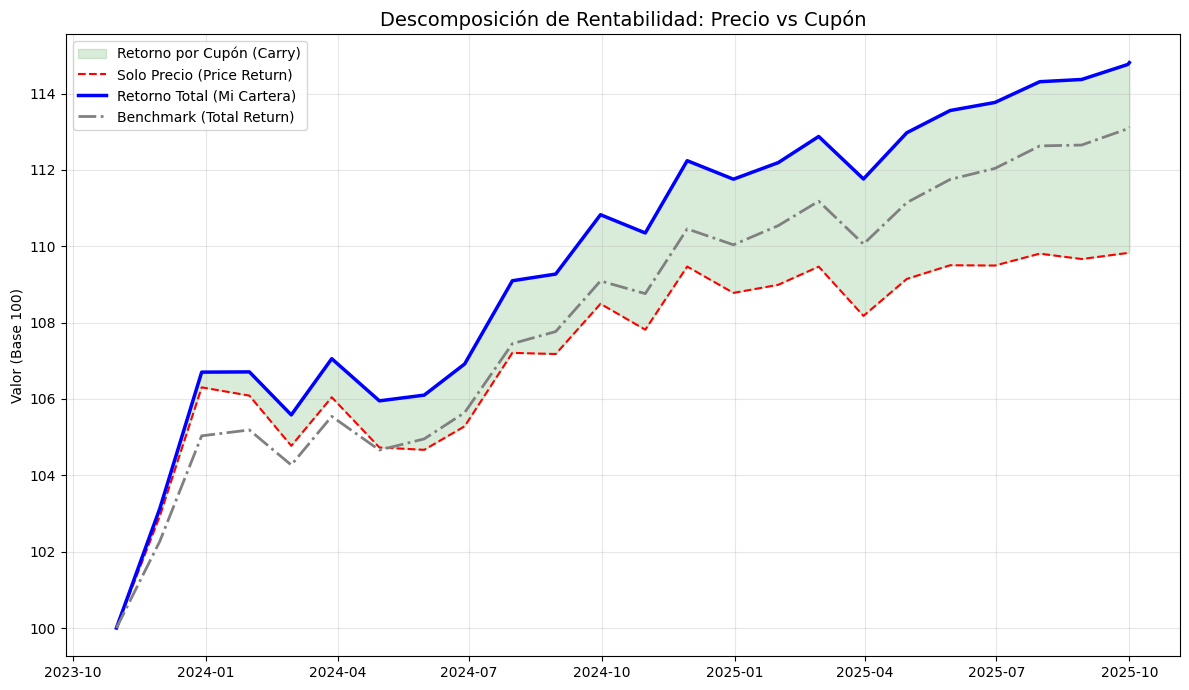

--- ATRIBUCIÓN DE RENTABILIDAD (FIN DEL PERIODO) ---
1. Rentabilidad Total Cartera: 14.81%
   ---------------------------
2. Contribución Precio:        9.87% (Movimiento de mercado)
3. Contribución Cupón:         4.95% (Carry / Intereses)

   -> El cupón explica el 33.4% del beneficio total.

--- COMPARATIVA ---
Rentabilidad Benchmark:        13.13%
Alpha (Exceso de Retorno):     1.68%


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARACIÓN DE DATOS
# ==============================================================================
print("--- Iniciando Backtest: Descomposición Precio vs Cupón ---")

# A) Generación de fechas de rebalanceo (Último día hábil real de cada mes)
rebal_dates = df_bonos_final.reset_index().groupby(
    pd.Grouper(key=df_bonos_final.index.name or 'index', freq='ME')
)[df_bonos_final.index.name or 'index'].max().dropna().values
rebal_dates = pd.to_datetime(rebal_dates).sort_values()

# B) Recuperamos Cupones Nominales (Datos estáticos)
# Aseguramos que están en tanto por uno (ej. 0.045 para 4.5%)
universo_cupones = universo_valoracion[['Coupon']].copy()
universo_cupones['Coupon'] = pd.to_numeric(universo_cupones['Coupon'], errors='coerce').fillna(0)
if universo_cupones['Coupon'].mean() > 1:
    universo_cupones['Coupon'] = universo_cupones['Coupon'] / 100.0

# C) Benchmark (Total Return)
try:
    col_bench = [c for c in df_mercado_final.columns if 'RECM' in c or 'TREU' in c][0]
    bench_series = df_mercado_final[col_bench]
    # Normalizamos base 100 al inicio del backtest
    start_date = rebal_dates[0]
    if start_date in bench_series.index:
        base_val = bench_series.loc[start_date]
        bench_nav = (bench_series / base_val) * 100
    else:
        # Si la fecha exacta no está, reindexamos
        bench_nav = (bench_series / bench_series.iloc[0]) * 100
except:
    bench_nav = None
    print("⚠️ No se encontró el Benchmark.")

# ==============================================================================
# 2. MOTOR DEL BACKTEST (CON DESGLOSE)
# ==============================================================================

# Índices Base 100
nav_total = [100.0]
nav_precio = [100.0]  # Solo variación de capital (Price Return)

fechas_nav = [rebal_dates[0]]

cap_total = 100.0
cap_precio = 100.0

# Iteramos mes a mes
for i in range(1, len(rebal_dates)):
    t_prev = rebal_dates[i-1] # Fecha Compra
    t_curr = rebal_dates[i]   # Fecha Valoración
    
    # --- 1. SELECCIÓN (SCREENING) ---
    try:
        precios_inicio = df_bonos_final.loc[t_prev].dropna()
    except KeyError: continue
    
    bonos_vivos = precios_inicio.index
    if len(bonos_vivos) == 0:
        # Si estamos en cash, mantenemos valor
        nav_total.append(cap_total)
        nav_precio.append(cap_precio)
        fechas_nav.append(t_curr)
        continue
        
    # --- 2. CÁLCULOS DE RETORNO INDIVIDUAL ---
    # Precio final (Mark-to-Market). Si falta, asumimos 100 (amortización/call) o precio anterior.
    # Para ser conservadores ante iliquidez, usamos precio_inicio si falta dato (retorno 0).
    # Para capturar amortizaciones, usaríamos 100. Usamos 100 como proxy de "bono termina".
    precios_fin = df_bonos_final.loc[t_curr, bonos_vivos].fillna(100.0)
    
    # A) Componente Precio (Price Return)
    # Variación pura de cotización: (P_fin / P_inicio) - 1
    ret_precio_indiv = (precios_fin / precios_inicio) - 1
    
    # B) Componente Cupón (Carry Return) - Metodología Current Yield
    # Recuperamos cupón nominal
    cupones_nominales = universo_cupones.reindex(bonos_vivos)['Coupon'].fillna(0)
    
    # Calculamos rentabilidad real de compra: Cupón / Precio Pagado
    # Nota: Precios suelen ser ~100. Cupones ~0.04. Ajustamos unidades: (0.04 * 100) / 98.0
    current_yields = (cupones_nominales * 100) / precios_inicio
    
    # Días de devengo
    dias = (t_curr - t_prev).days
    
    # Retorno cupón: Yield_Anual * Fracción_Año
    ret_cupon_indiv = current_yields * (dias / 365.0)
    
    # --- 3. AGREGACIÓN CARTERA (EQUIPONDERADA) ---
    # El peso es 1/N implícito al hacer la media simple
    port_ret_precio = ret_precio_indiv.mean()
    port_ret_cupon = ret_cupon_indiv.mean()
    
    # Retorno Total = Suma de componentes
    port_ret_total = port_ret_precio + port_ret_cupon
    
    # --- 4. COMPOSICIÓN (COMPOUNDING) ---
    # Actualizamos los índices
    cap_total = cap_total * (1 + port_ret_total)
    cap_precio = cap_precio * (1 + port_ret_precio)
    
    nav_total.append(cap_total)
    nav_precio.append(cap_precio)
    fechas_nav.append(t_curr)

# DataFrame de Resultados
df_backtest = pd.DataFrame({
    'Total Return': nav_total,
    'Price Return': nav_precio
}, index=fechas_nav)

# Columna auxiliar para ver cuánto aporta el cupón acumulado (diferencia)
df_backtest['Efecto Cupón'] = df_backtest['Total Return'] - df_backtest['Price Return']

# ==============================================================================
# 3. VISUALIZACIÓN FINAL
# ==============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

# A) Área del Cupón (Carry)
# Rellenamos entre la línea de solo precio y la total
ax.fill_between(df_backtest.index, df_backtest['Price Return'], df_backtest['Total Return'], 
                color='green', alpha=0.15, label='Retorno por Cupón (Carry)')

# B) Líneas Principales
ax.plot(df_backtest.index, df_backtest['Price Return'], label='Solo Precio (Price Return)', color='red', linewidth=1.5, linestyle='--')
ax.plot(df_backtest.index, df_backtest['Total Return'], label='Retorno Total (Mi Cartera)', color='blue', linewidth=2.5)

# C) Benchmark
if bench_nav is not None:
    # Reindexamos para asegurar alineación perfecta en el gráfico
    bench_plot = bench_nav.reindex(df_backtest.index, method='ffill')
    # Renormalizamos a 100 en la fecha exacta de inicio de NUESTRA cartera
    bench_plot = (bench_plot / bench_plot.iloc[0]) * 100
    ax.plot(bench_plot, label='Benchmark (Total Return)', color='gray', linestyle='-.', linewidth=2)

ax.set_title('Descomposición de Rentabilidad: Precio vs Cupón', fontsize=14)
ax.set_ylabel('Valor (Base 100)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================================================
# 4. ATRIBUCIÓN DE RESULTADOS
# ==============================================================================
ret_total_abs = (df_backtest['Total Return'].iloc[-1] / 100) - 1
ret_price_abs = (df_backtest['Price Return'].iloc[-1] / 100) - 1
impacto_cupon = ret_total_abs - ret_price_abs

print("--- ATRIBUCIÓN DE RENTABILIDAD (FIN DEL PERIODO) ---")
print(f"1. Rentabilidad Total Cartera: {ret_total_abs:.2%}")
print(f"   ---------------------------")
print(f"2. Contribución Precio:        {ret_price_abs:.2%} (Movimiento de mercado)")
print(f"3. Contribución Cupón:         {impacto_cupon:.2%} (Carry / Intereses)")
print(f"\n   -> El cupón explica el {(impacto_cupon/ret_total_abs)*100:.1f}% del beneficio total.")

if bench_nav is not None:
    bench_final = (bench_plot.iloc[-1] / 100) - 1
    print(f"\n--- COMPARATIVA ---")
    print(f"Rentabilidad Benchmark:        {bench_final:.2%}")
    print(f"Alpha (Exceso de Retorno):     {ret_total_abs - bench_final:.2%}")

--- Análisis de Factores: Efecto Tamaño (Size) ---
Umbral Small (< 20%): 500,000,000
Umbral Large (> 80%): 1,000,000,000
Cantidad: 799 Pequeños vs 570 Grandes


C:\Users\javie\AppData\Local\Temp\ipykernel_42344\4021950296.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precios = df_bonos_final[ids_validos].fillna(method='ffill')
C:\Users\javie\AppData\Local\Temp\ipykernel_42344\4021950296.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precios = df_bonos_final[ids_validos].fillna(method='ffill')


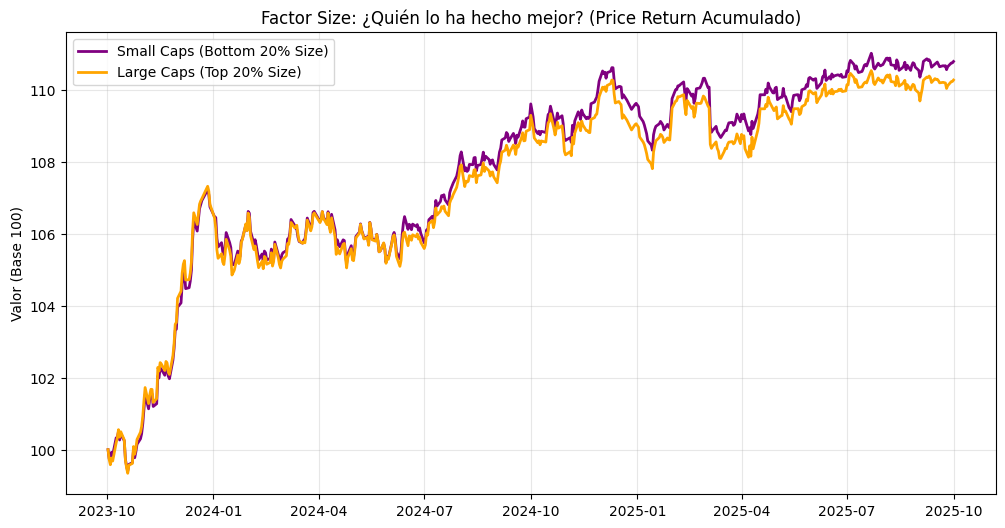

Retorno Acumulado Small: 10.79%
Retorno Acumulado Large: 10.27%

✅ CONCLUSIÓN: Los bonos pequeños (Small Caps) han batido a los grandes.
   Esto explica por qué tu cartera Equiponderada bate al índice (Market Cap).
   Has capturado la 'Prima de Iliquidez/Tamaño'.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("--- Análisis de Factores: Efecto Tamaño (Size) ---")

# 1. PREPARACIÓN
# Usamos el Outstanding Amount del universo original
# Aseguramos que el índice es correcto para cruzar
try:
    df_size = universo_valoracion[['Outstanding Amount']].copy()
    # Limpieza: Convertir a numérico (a veces viene con divisas o textos)
    df_size['Outstanding Amount'] = pd.to_numeric(df_size['Outstanding Amount'], errors='coerce')
except:
    print("❌ No se encuentra la columna 'Outstanding Amount'.")
    df_size = None

if df_size is not None:
    # Eliminamos nulos
    df_size = df_size.dropna()
    
    # 2. CLASIFICACIÓN (LARGE vs SMALL)
    # Calculamos los cortes (quintiles)
    umbral_small = df_size['Outstanding Amount'].quantile(0.20) # El 20% más pequeño
    umbral_large = df_size['Outstanding Amount'].quantile(0.80) # El 20% más grande
    
    ids_small = df_size[df_size['Outstanding Amount'] <= umbral_small].index
    ids_large = df_size[df_size['Outstanding Amount'] >= umbral_large].index
    
    print(f"Umbral Small (< 20%): {umbral_small:,.0f}")
    print(f"Umbral Large (> 80%): {umbral_large:,.0f}")
    print(f"Cantidad: {len(ids_small)} Pequeños vs {len(ids_large)} Grandes")

    # 3. MOTOR DE BACKTEST SIMPLIFICADO (Solo Price Return para ver tendencia)
    # Hacemos una versión vectorizada rápida sin carry detallado para ver la tendencia de precios
    # (El carry suele ser mayor en Small Caps, así que esto es una cota inferior)
    
    def calcular_indice_precio(ids_filtro, nombre):
        # Filtramos precios solo de esos bonos
        # Intersección con los que tenemos precios históricos
        ids_validos = df_bonos_final.columns.intersection(ids_filtro)
        precios = df_bonos_final[ids_validos].fillna(method='ffill')
        
        # Retorno diario promedio equiponderado de ese grupo
        ret_diario = precios.pct_change().mean(axis=1).fillna(0)
        
        # Índice base 100
        indice = (1 + ret_diario).cumprod() * 100
        indice.name = nombre
        return indice

    idx_small = calcular_indice_precio(ids_small, 'Small Caps (Bonos Pequeños)')
    idx_large = calcular_indice_precio(ids_large, 'Large Caps (Bonos Gigantes)')
    
    # 4. VISUALIZACIÓN
    plt.figure(figsize=(12, 6))
    plt.plot(idx_small, label='Small Caps (Bottom 20% Size)', color='purple', linewidth=2)
    plt.plot(idx_large, label='Large Caps (Top 20% Size)', color='orange', linewidth=2)
    
    # Añadimos tu cartera total como referencia (Línea punteada)
    # (Recuperamos nav_precio del paso anterior si existe, o lo omitimos)
    # plt.plot(df_backtest.index, df_backtest['Price Return'], 'k--', label='Cartera Total', alpha=0.5)

    plt.title('Factor Size: ¿Quién lo ha hecho mejor? (Price Return Acumulado)')
    plt.ylabel('Valor (Base 100)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Rendimiento final
    ret_small = idx_small.iloc[-1] - 100
    ret_large = idx_large.iloc[-1] - 100
    print(f"Retorno Acumulado Small: {ret_small:.2f}%")
    print(f"Retorno Acumulado Large: {ret_large:.2f}%")
    
    if ret_small > ret_large:
        print("\n✅ CONCLUSIÓN: Los bonos pequeños (Small Caps) han batido a los grandes.")
        print("   Esto explica por qué tu cartera Equiponderada bate al índice (Market Cap).")
        print("   Has capturado la 'Prima de Iliquidez/Tamaño'.")
    else:
        print("\n❓ CONCLUSIÓN: Los grandes han batido a los pequeños.")
        print("   Si tu cartera gana, debe ser por otro factor (ej. High Yield vs Investment Grade).")


--- Análisis de Factores Adicionales ---


C:\Users\javie\AppData\Local\Temp\ipykernel_42344\3745311177.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precios = df_bonos_final[ids_validos].fillna(method='ffill')
C:\Users\javie\AppData\Local\Temp\ipykernel_42344\3745311177.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precios = df_bonos_final[ids_validos].fillna(method='ffill')


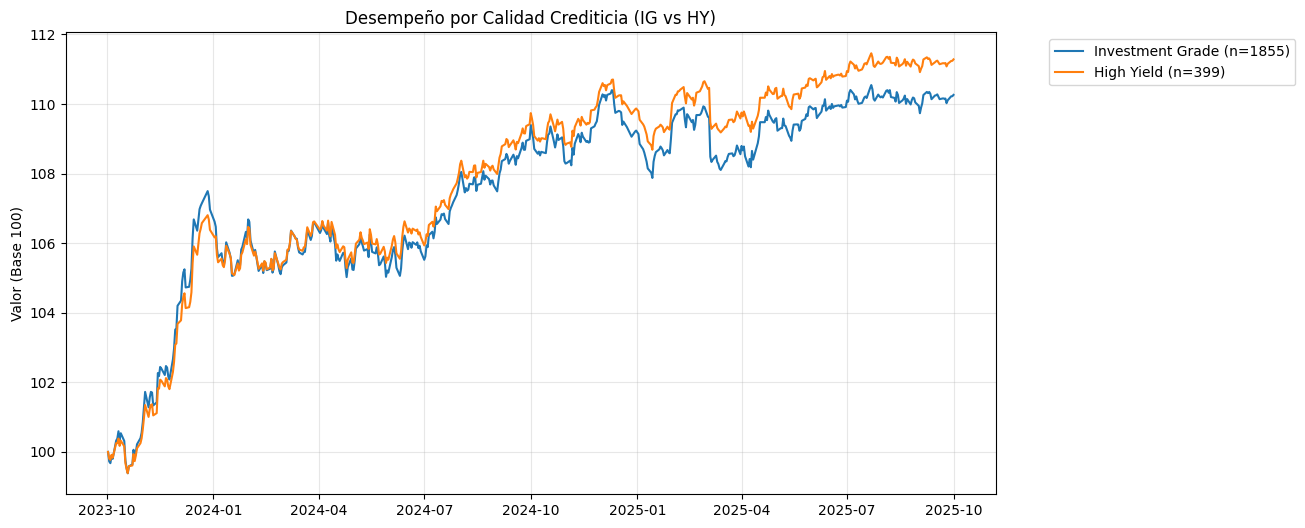


Ranking por Calidad Crediticia (IG vs HY) (Retorno Acumulado):
High Yield          11.282189
Investment Grade    10.261723
dtype: float64
...
High Yield          11.282189
Investment Grade    10.261723
dtype: float64


C:\Users\javie\AppData\Local\Temp\ipykernel_42344\3745311177.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precios = df_bonos_final[ids_validos].fillna(method='ffill')
C:\Users\javie\AppData\Local\Temp\ipykernel_42344\3745311177.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precios = df_bonos_final[ids_validos].fillna(method='ffill')
C:\Users\javie\AppData\Local\Temp\ipykernel_42344\3745311177.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precios = df_bonos_final[ids_validos].fillna(method='ffill')
C:\Users\javie\AppData\Local\Temp\ipykernel_42344\3745311177.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inst

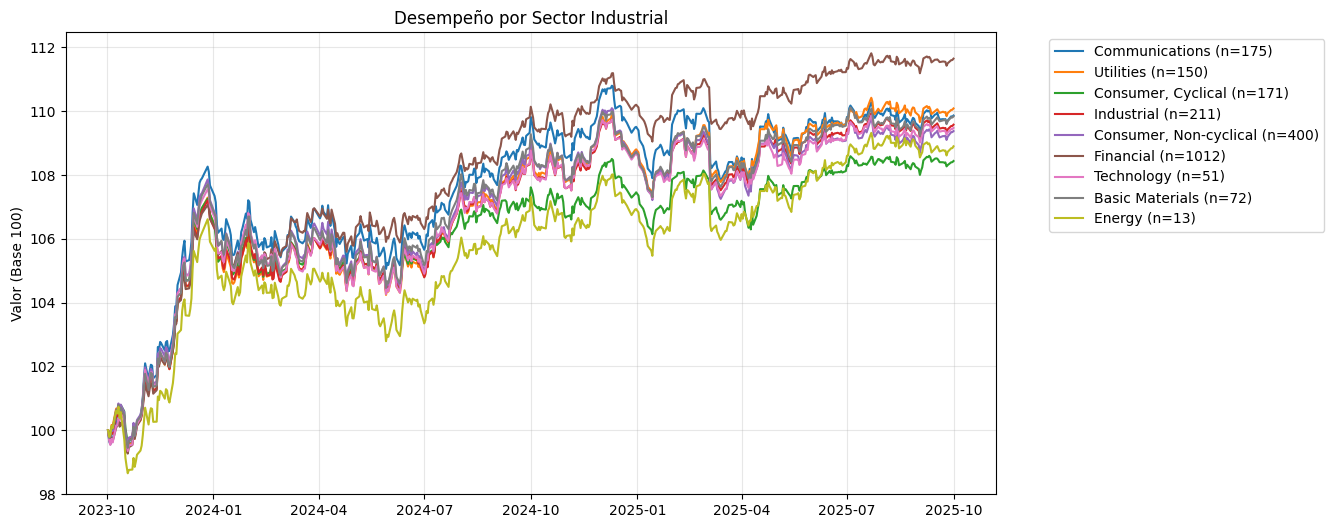


Ranking por Sector Industrial (Retorno Acumulado):
Financial          11.648352
Utilities          10.087798
Communications      9.865621
Basic Materials     9.836063
Industrial          9.577945
dtype: float64
...
Consumer, Non-cyclical    9.378658
Energy                    8.900330
Consumer, Cyclical        8.439550
dtype: float64


In [11]:
print("\n--- Análisis de Factores Adicionales ---")

# Función auxiliar para calcular retorno acumulado por grupo
def analizar_factor(columna_factor, nombre_factor):
    # Agrupamos por el factor y calculamos el retorno medio de cada grupo
    # Usamos una lógica simplificada de Price Return acumulado
    resultados = {}
    
    grupos = universo_valoracion[columna_factor].dropna().unique()
    
    plt.figure(figsize=(12, 6))
    
    for grupo in grupos:
        # Filtramos bonos de este grupo
        ids_grupo = universo_valoracion[universo_valoracion[columna_factor] == grupo].index
        ids_validos = df_bonos_final.columns.intersection(ids_grupo)
        
        if len(ids_validos) < 10: continue # Ignoramos grupos muy pequeños
            
        # Calculamos índice
        precios = df_bonos_final[ids_validos].fillna(method='ffill')
        ret_diario = precios.pct_change().mean(axis=1).fillna(0)
        indice = (1 + ret_diario).cumprod() * 100
        
        plt.plot(indice, label=f"{grupo} (n={len(ids_validos)})")
        resultados[grupo] = indice.iloc[-1] - 100

    plt.title(f'Desempeño por {nombre_factor}')
    plt.ylabel('Valor (Base 100)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Mostrar tabla ordenada de ganadores
    df_res = pd.Series(resultados).sort_values(ascending=False)
    print(f"\nRanking por {nombre_factor} (Retorno Acumulado):")
    print(df_res.head(5))
    print("...")
    print(df_res.tail(3))

# 1. TEST DE RATING (Agrupamos un poco para no tener 20 líneas)
# Creamos una columna simplificada: IG vs HY
def simplificar_rating(r):
    if pd.isna(r): return 'N/A'
    if any(x in str(r) for x in ['AAA', 'AA', 'A', 'BBB']): return 'Investment Grade'
    return 'High Yield'

universo_valoracion['Rating_Group'] = universo_valoracion['Rating'].apply(simplificar_rating)
analizar_factor('Rating_Group', 'Calidad Crediticia (IG vs HY)')

# 2. TEST DE SECTOR
# Usamos 'Industry Sector'
analizar_factor('Industry Sector', 'Sector Industrial')

# - ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
Lo correcto sería comprar contra el ask y vender contra el bid. Es algo que se podría replicar incluyendo un coste de ejecución en el rebalanceo e.g. 15bps por transacción. Esa fricción reduciría la rentabilidad total, aunque probablemente tendría sentido pasar el rebalanceo a 3 meses (es altamente probable que tuviese mejor rentabilidad que con una frecuencia de rebalanceo mayor).

# - ¿Se te ocurre algún otro benchmark que se podría utilizar?

Propuesta de Nuevos Benchmarks

3 alternativas:

1. El Benchmark "Interno" (La Media del Universo)
Simplemente calcular el retorno promedio diario de todos los bonos disponibles en tu base de datos df_bonos_final, sin aplicar reglas de rebalanceo mensual ni selección.¿Por qué usarlo? Es la medida más pura de "El Mercado Disponible". Te dice: "¿Mi estrategia de rebalancear mensualmente aporta valor frente a la estrategia pasiva de 'comprar todo lo que hay' y no tocarlo? "Elimina el sesgo de selección (porque usas los mismos activos).

2. Un Índice High Yield (Euro High Yield Index)
Un índice como el Bloomberg Pan-European High Yield (LP02TREU) o el iBoxx EUR Liquid High Yield.¿Por qué usarlo?Como tu cartera equiponderada sobrepondera el riesgo, es muy probable que su comportamiento (volatilidad y retorno) se parezca más a un índice High Yield que al de Grado de Inversión (RECMTREU).Prueba: Si tu cartera tiene una correlación del 0.9 con el High Yield y solo del 0.5 con el Investment Grade, tu verdadero benchmark debería ser el High Yield.

3. El Benchmark Sintético (Composite Benchmark)
Crear un benchmark que se ajuste a la distribución de ratings, sectores, emisores, duración, tipo de bono ... como media ponderada de varios tipos e.g. 15% High Yield, 70% Investment Grade, 15% Sovereigns. Puedes ajustarlo todo lo que quieras.


### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

In [ ]:
### Optimizer 1 - Simplificado, con constraints marcadas desde el principio y reduciendo el unvierso de candidatos de manera sustancial

from scipy.optimize import minimize
import pandas as pd
import numpy as np

print("--- CONSTRUCCIÓN DE CARTERA ÓPTIMA ---")

# ==============================================================================
# 1. PREPARACIÓN DE DATOS (Matriz de Características)
# ==============================================================================

# Unimos los datos necesarios en un solo DF
df_opt = df_riesgo[['Yield (%)', 'Duration', 'Precio Mercado']].copy()
cols_extra = ['Outstanding Amount', 'Seniority', 'Rating', 'Issuer', 'Industry Sector']
df_opt = df_opt.join(subset_universo[cols_extra])

# Limpieza previa
df_opt['Outstanding Amount'] = pd.to_numeric(df_opt['Outstanding Amount'], errors='coerce').fillna(0)
df_opt['Yield (%)'] = pd.to_numeric(df_opt['Yield (%)'], errors='coerce').fillna(0)
df_opt['Duration'] = pd.to_numeric(df_opt['Duration'], errors='coerce').fillna(100) # Penalizar nulos

# ==============================================================================
# 2. FASE 1: FILTRADO (HARD CONSTRAINTS)
# ==============================================================================

# A. Tamaño > 500M
mask_size = df_opt['Outstanding Amount'] > 500_000_000

# B. Seniority (No Subordinada)
# Buscamos que NO contenga 'Sub' en el texto (case insensitive)
mask_senior = ~df_opt['Seniority'].str.contains('Sub|Jr|Tier', case=False, na=False)

# C. Rating (Definir quién es HY para la restricción posterior)
def is_high_yield(r):
    if pd.isna(r): return True # Ante la duda, es arriesgado
    # Lista de IG: AAA, AA, A, BBB
    if any(ig in str(r) for ig in ['AAA', 'AA', 'A', 'BBB']):
        if 'BB+' in str(r): return True # BBB+ es IG, BB+ es HY. Cuidado con el string matching.
        return False
    return True

df_opt['is_HY'] = df_opt['Rating'].apply(is_high_yield)

# Aplicamos Filtro Global
df_pool = df_opt[mask_size & mask_senior].copy()
df_pool = df_pool[df_pool['Yield (%)'] > 0] # Solo yields positivos y lógicos

print(f"Universo Inicial: {len(df_opt)}")
print(f"Universo Elegible (Size > 500M & Senior): {len(df_pool)}")

# ==============================================================================
# 3. FASE 2: PRE-SELECCIÓN (CANDIDATOS)
# ==============================================================================
# Para facilitar al optimizador, nos quedamos con los Top N bonos por Yield.
# Pero debemos asegurarnos de tener suficientes de CADA grupo (HY y IG) y duración corta/larga.

# Estrategia:
# 1. Cogemos los Top 20 HY (para llenar el cubo del 10%)
# 2. Cogemos los Top 50 IG (para el 90% restante)
# 3. Añadimos algunos bonos de duración muy corta (Cash substitutes) para bajar la duración media si hace falta.

top_hy = df_pool[df_pool['is_HY']].nlargest(20, 'Yield (%)')
top_ig = df_pool[~df_pool['is_HY']].nlargest(60, 'Yield (%)')
# Bonos cortos IG (Duración < 1) para gestionar restricción
top_short = df_pool[(~df_pool['is_HY']) & (df_pool['Duration'] < 1.5)].nlargest(20, 'Yield (%)')

# Unimos y quitamos duplicados
candidates = pd.concat([top_hy, top_ig, top_short]).drop_duplicates()

print(f"Candidatos para el optimizador: {len(candidates)}")

# ==============================================================================
# 4. FASE 3: OPTIMIZADOR MATEMÁTICO
# ==============================================================================

n_assets = len(candidates)
yields = candidates['Yield (%)'].values
durations = candidates['Duration'].values
is_hy_vec = candidates['is_HY'].values.astype(int)
issuers = candidates['Issuer'].values

# Matriz de Issuer (One-hot encoding manual para restricción)
# Crea una matriz donde cada fila es un emisor único y las columnas son los bonos
unique_issuers = np.unique(issuers)
issuer_matrix = np.zeros((len(unique_issuers), n_assets))
for i, issuer in enumerate(unique_issuers):
    issuer_matrix[i] = (issuers == issuer).astype(float)

# --- Configuración de Scipy ---

# Función a MINIMIZAR (Negativo del Yield Ponderado)
def objective(weights):
    return -np.sum(weights * yields)

# Restricciones (Constraints)
cons = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},           # Suma pesos = 1
    {'type': 'ineq', 'fun': lambda w: 3 - np.sum(w * durations)}, # Duración <= 3 (3 - D >= 0)
    {'type': 'ineq', 'fun': lambda w: 0.10 - np.sum(w * is_hy_vec)}, # HY <= 10%
]

# Restricción de Emisor (Max 15% por emisor)
for i in range(len(unique_issuers)):
    cons.append({'type': 'ineq', 'fun': lambda w, i=i: 0.15 - np.sum(w * issuer_matrix[i])})

# Límites por activo (0 a 10%)
bounds = [(0, 0.10) for _ in range(n_assets)]

# Ejecución
print("-> Optimizando pesos...")
init_guess = np.ones(n_assets) / n_assets
opt_result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

# ==============================================================================
# 5. RESULTADOS Y CARTERA FINAL
# ==============================================================================

if opt_result.success:
    print("\n✅ Optimización Exitosa.")
    weights_opt = opt_result.x
    
    # Asignamos pesos y filtramos los > 0.001 (basura numérica)
    candidates['Peso Final (%)'] = weights_opt * 100
    cartera_final = candidates[candidates['Peso Final (%)'] > 0.01].copy()
    
    # Ordenamos
    cartera_final = cartera_final.sort_values('Peso Final (%)', ascending=False)
    
    # --- MÉTRICAS DE LA CARTERA ---
    w_final = cartera_final['Peso Final (%)'] / 100
    yield_port = np.sum(w_final * cartera_final['Yield (%)'])
    dur_port = np.sum(w_final * cartera_final['Duration'])
    hy_pct = np.sum(w_final * cartera_final['is_HY']) * 100
    num_bonos = len(cartera_final)
    
    print("-" * 40)
    print(f"Rentabilidad Esperada (Yield): {yield_port:.2f}%")
    print(f"Duración Cartera:              {dur_port:.2f} años (Max 3.0)")
    print(f"Exposición HY:                 {hy_pct:.2f}% (Max 10%)")
    print(f"Número de Bonos:               {num_bonos}")
    print("-" * 40)
    
    print("\nTop 10 Posiciones:")
    print(cartera_final[['Issuer', 'Rating', 'Yield (%)', 'Duration', 'Peso Final (%)']].head(10))
    
    # Validaciones extra
    print("\nValidación de Restricciones:")
    print(f"- Max peso individual: {cartera_final['Peso Final (%)'].max():.2f}% (OK si <= 10)")
    print(f"- Max peso emisor:     {cartera_final.groupby('Issuer')['Peso Final (%)'].sum().max():.2f}% (OK si <= 15)")
    
else:
    print("❌ La optimización falló. Revisa si las restricciones son imposibles de cumplir.")
    print(opt_result.message)









--- CONSTRUCCIÓN DE CARTERA ÓPTIMA ---
Universo Inicial: 2255
Universo Elegible (Size > 500M & Senior): 1353
Candidatos para el optimizador: 100
-> Optimizando pesos...

✅ Optimización Exitosa.
----------------------------------------
Rentabilidad Esperada (Yield): 5.34%
Duración Cartera:              3.00 años (Max 3.0)
Exposición HY:                 10.00% (Max 10%)
Número de Bonos:               12
----------------------------------------

Top 10 Posiciones:
                                Issuer Rating  Yield (%)  Duration  \
XS1186176571      HEATHROW FUNDING LTD   BBB+  21.283700  0.300439   
XS2356041165             STELLANTIS NV    BBB   4.515512  6.773231   
XS2193983108         UPJOHN FINANCE BV   BBB-   4.133038  5.822770   
XS2397252011  HEIMSTADEN BOSTAD TRESRY   BBB-   4.069700  5.312296   
XS2597994065       GLOBAL PAYMENTS INC   BBB-   3.741765  4.496097   
FR0013231768                 IMERYS SA   BBB-   3.220917  0.991399   
XS2406914346    HIGHLAND HOLDINGS SARL    BB

In [ ]:
### Optimizer 2 - Sin reducir número de candidatos. Más compute intensive pero más robusto.

from scipy.optimize import minimize
import pandas as pd
import numpy as np

print("--- CONSTRUCCIÓN DE CARTERA ÓPTIMA (ENFOQUE EN 2 ETAPAS) ---")

# ==============================================================================
# 1. PREPARACIÓN Y FILTRADO (HARD CONSTRAINTS)
# ==============================================================================

# Datos base
df_opt = df_riesgo[['Yield (%)', 'Duration', 'Precio Mercado']].copy()
cols_extra = ['Outstanding Amount', 'Seniority', 'Rating', 'Issuer', 'Industry Sector']
df_opt = df_opt.join(subset_universo[cols_extra])

# Limpieza numérica
df_opt['Outstanding Amount'] = pd.to_numeric(df_opt['Outstanding Amount'], errors='coerce').fillna(0)
df_opt['Yield (%)'] = pd.to_numeric(df_opt['Yield (%)'], errors='coerce').fillna(0)
df_opt['Duration'] = pd.to_numeric(df_opt['Duration'], errors='coerce').fillna(100) # Penalizar nulos con duración alta

# --- FILTROS ---
# 1. Tamaño > 500M
mask_size = df_opt['Outstanding Amount'] > 500_000_000

# 2. Seniority (No Sub)
mask_senior = ~df_opt['Seniority'].str.contains('Sub|Jr|Tier', case=False, na=False)

# 3. Yield Positivo y Lógico (evitar bonos distressed con yields de 1000%)
mask_logic = (df_opt['Yield (%)'] > 0) & (df_opt['Yield (%)'] < 50)

# 4. Definición HY
def is_high_yield(r):
    if pd.isna(r): return True
    if any(ig in str(r) for ig in ['AAA', 'AA', 'A', 'BBB']):
        if 'BB+' in str(r): return True
        return False
    return True

df_opt['is_HY'] = df_opt['Rating'].apply(is_high_yield)

# --- UNIVERSO ELEGIBLE ---
# Pasamos TODOS los que cumplen requisitos duros. No preseleccionamos por yield.
candidates = df_opt[mask_size & mask_senior & mask_logic].copy()

print(f"Universo Total Inicial: {len(df_opt)}")
print(f"Universo Elegible para el Solver: {len(candidates)}")

# ==============================================================================
# 2. MOTOR DE OPTIMIZACIÓN (Funciones Reutilizables)
# ==============================================================================

def ejecutar_optimizacion(df_input, max_peso_individual=0.10):
    """
    Ejecuta SLSQP sobre el dataframe dado.
    """
    n = len(df_input)
    # Vectores numpy para velocidad
    yields = df_input['Yield (%)'].values
    durations = df_input['Duration'].values
    hy_vec = df_input['is_HY'].values.astype(float)
    
    # Matriz emisores (One-Hot) para restricción 15%
    issuers = df_input['Issuer'].values
    unique_issuers, issuer_indices = np.unique(issuers, return_inverse=True)
    n_issuers = len(unique_issuers)
    
    # Función Objetivo: Maximizar Yield (Minimizar -Yield)
    fun = lambda w: -np.sum(w * yields)
    
    # Restricciones
    cons = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},             # Suma = 1
        {'type': 'ineq', 'fun': lambda w: 3.0 - np.sum(w * durations)}, # Duración <= 3
        {'type': 'ineq', 'fun': lambda w: 0.10 - np.sum(w * hy_vec)},   # HY <= 10%
    ]
    
    # Restricción Emisor (Vectorizada para velocidad)
    # Creamos una restricción por cada emisor que tenga más de 1 bono
    # (Si solo tiene 1 bono, la restricción de peso individual del 10% ya cubre el 15%)
    for i in range(n_issuers):
        # Índices de los bonos de este emisor
        idx_emisor = np.where(issuer_indices == i)[0]
        if len(idx_emisor) > 1: # Solo si hay riesgo de acumulación
            cons.append({'type': 'ineq', 'fun': lambda w, idx=idx_emisor: 0.15 - np.sum(w[idx])})

    # Límites (Bounds)
    bounds = [(0, max_peso_individual) for _ in range(n)]
    
    # Semilla inicial (Equiponderada)
    x0 = np.ones(n) / n
    
    # Ejecución
    # Usamos maxiter alto porque el problema es grande
    result = minimize(fun, x0, method='SLSQP', bounds=bounds, constraints=cons, options={'maxiter': 1000})
    
    return result

# ==============================================================================
# 3. ETAPA 1: OPTIMIZACIÓN RELAJADA (TODO EL UNIVERSO)
# ==============================================================================
print("\n-> Etapa 1: Optimizando universo completo (Buscando estructura ideal)...")

res_stage1 = ejecutar_optimizacion(candidates)

if not res_stage1.success:
    print("❌ Etapa 1 Fallida. Relaja restricciones (ej. Duración).")
    print(res_stage1.message)
else:
    print(f"✅ Etapa 1 Exitosa. Yield Teórico Máximo: {-res_stage1.fun:.2f}%")
    
    # Asignamos pesos temporales
    candidates['Peso_Stage1'] = res_stage1.x
    
    # Filtramos los activos con peso relevante (> 0.1%)
    # Esto elimina el "ruido" numérico del optimizador
    activos_relevantes = candidates[candidates['Peso_Stage1'] > 0.001].copy()
    print(f"   Activos con peso > 0.1%: {len(activos_relevantes)}")

    # ==============================================================================
    # 4. ETAPA 2: SELECCIÓN Y RE-OPTIMIZACIÓN (CARDINALIDAD MAX 20)
    # ==============================================================================
    print("\n-> Etapa 2: Selección Top 20 y Re-calibrado...")
    
    # Seleccionamos los 20 con mayor peso de la Etapa 1
    # Esta es la mejor heurística: los que el solver eligió con más fuerza
    top_20_candidates = activos_relevantes.nlargest(20, 'Peso_Stage1').copy()
    
    # Ejecutamos el optimizador SOLO con estos 20
    # Nota: Al reducir activos, puede ser más difícil cumplir restricciones (ej. duración).
    # El solver ajustará los pesos para lograrlo.
    res_stage2 = ejecutar_optimizacion(top_20_candidates, max_peso_individual=0.10)
    
    if res_stage2.success:
        print(f"✅ Etapa 2 Exitosa. Cartera Final Generada.")
        
        # Asignar pesos finales
        top_20_candidates['Peso Final (%)'] = res_stage2.x * 100
        
        # Limpieza final (quitar ceros si los hubiera)
        cartera_final = top_20_candidates[top_20_candidates['Peso Final (%)'] > 0.01].copy()
        cartera_final = cartera_final.sort_values('Peso Final (%)', ascending=False)
        
        # --- REPORTE FINAL ---
        w = cartera_final['Peso Final (%)'] / 100
        
        # Métricas Ponderadas
        y_port = (w * cartera_final['Yield (%)']).sum()
        d_port = (w * cartera_final['Duration']).sum()
        hy_exp = (w * cartera_final['is_HY']).sum() * 100
        
        print("\n" + "="*40)
        print("   CARTERA ÓPTIMA FINAL (Max 20 Bonos)")
        print("="*40)
        print(f"Número de Activos:      {len(cartera_final)}")
        print(f"Yield (TIR) Cartera:    {y_port:.2f}%")
        print(f"Duración Efectiva:      {d_port:.2f} años (Límite 3.0)")
        print(f"Exposición High Yield:  {hy_exp:.2f}%   (Límite 10%)")
        print("-" * 40)
        
        cols_show = ['Issuer', 'Rating', 'Yield (%)', 'Duration', 'Outstanding Amount', 'Peso Final (%)']
        print(cartera_final[cols_show].head(20))
        
    else:
        print("❌ Etapa 2 Fallida. Los 20 mejores activos no pueden cumplir las restricciones por sí solos.")
        print("   Intenta aumentar el límite a Top 25 o relajar la restricción de Duración.")
        print(res_stage2.message)

--- CONSTRUCCIÓN DE CARTERA ÓPTIMA (ENFOQUE EN 2 ETAPAS) ---
Universo Total Inicial: 2255
Universo Elegible para el Solver: 1353

-> Etapa 1: Optimizando universo completo (Buscando estructura ideal)...
✅ Etapa 1 Exitosa. Yield Teórico Máximo: 5.34%
   Activos con peso > 0.1%: 12

-> Etapa 2: Selección Top 20 y Re-calibrado...
✅ Etapa 2 Exitosa. Cartera Final Generada.

   CARTERA ÓPTIMA FINAL (Max 20 Bonos)
Número de Activos:      12
Yield (TIR) Cartera:    5.34%
Duración Efectiva:      3.00 años (Límite 3.0)
Exposición High Yield:  10.00%   (Límite 10%)
----------------------------------------
                                Issuer Rating  Yield (%)  Duration  \
XS1186176571      HEATHROW FUNDING LTD   BBB+  21.283700  0.300439   
XS1511787589            MORGAN STANLEY      A   2.901183  1.027654   
FR0013231768                 IMERYS SA   BBB-   3.220917  0.991399   
FR0013476090             RCI BANQUE SA    BBB   2.943653  0.997666   
XS2193983108         UPJOHN FINANCE BV   BBB-  

Las restricciones que tendría sentido incluir son las siguientes:
    1. Duración: 3 años
    2. 
    3. Rating --> High-Yield: no más del 10% de la cartera
    4. Rating --> Excluir emisores sin rating o por debajo de determinado umbral
    5. Divisa --> Excluir emisores en determinadas divisas
    6. Jurisdicción / Geografía --> Excluir emisores de determinadas jurisdicciones
    7. Seniority --> Deuda subordinada: excluida de la estrategia. Se puede hilar más fino (Junior, Unsecured, Secured ...)
    8. Liquidez --> Excluir emisiones con un bid-ask spread medio superior a X o con un volumen diario inferior a Y.
    9. Size --> Excluir emisores por debajo de determinado umbral de principal
    10. Size --> Excluir emisores por encima / debajo de determinado umbral de Market Cap
    11. Concentración sectorial --> Limitar la concentración sectorial (en particular en el sector financiero, que representa una parte muy importante del universo)
    12. Concentración por emisor --> Limitar la exposición a un mismo emisor
    13. Concentación agregada en sectores cíclicos --> Limitar la exposición agregada a sectores cíclicos (finaciero, industrial, energía, materiales básicos, consumo discrecional ...)
    14. Exclusión de emisores por ratios de liquidez (Net Debt / EBITDA, Debt to Equity, Current Ratio ...)
    15. Exclusión de emisores por distintas métricas (rentables si / no, flujo de caja positivo sí / no) 

##### <font color=#CC6600>Riesgo de crédito</font>

De cara a medir el riesgo de crédito, podemos utilizar distintas metodologías:
1. Método Tradicional (Weighted Average Rating Factor - WARF):
Asignar un valor numérico a cada rating (ej. AAA=1, BBB=600) y calcular la media ponderada. Es el estándar de la industria para reportar calidad crediticia agregada.

2. Método Cuantitativo (DTS - Duration Times Spread): DTS = Duración * Spread
Es la métrica moderna de riesgo de crédito. Mide cuánto perdería la cartera si los spreads de crédito se ensancharan un 1% relativo. Es mucho más precisa que el rating porque reacciona al mercado en tiempo real.

3. Método Probabilístico (PD Agregada):
Utilizar la columna PD 1YR (Probabilidad de Default) que tienes en el dataframe.
Calcular la Pérdida Esperada (Expected Loss) de la cartera: $\sum (Peso_i \times PD_i \times LGD_{estándar})$.

##### <font color=#CC6600>Riesgo de liquidez</font>

# Para gestionar el riesgo de liquidez:

1. Weighted Average Bid-Ask Spread
2. Weighted Average Days to Liquidation
3. Market Depth Score: Composite score with bid-ask spread, days to liquidation, non-trading days ...


##### <font color=#CC6600>Backtest</font>

# Cómo diseñar el backtest de la estrategia:

Pre-Backtest:
1. Fraccionar el dataset. Necesitamos data histórica inicial para calcular la matriz de covarianza y retornos esperados.
2. Definir la frecuencia de rebalanceo

Optimizador en bucle:
1. Filtrar el universo de bonos en base a restricciones
2. Ejecutar algoritmo de optimización (maximizar YTM en cada punto de rebalanceo) sujeto a restricciones:
            1. Limitaciones de rating
            2. Limitaciones de seniority
            3. Limitaciones de ejecución e.g. no superar el volumen medio diario
   
3. Aplicar costes de transacción reales (operar sobre bid-ask spreads)

4. Calcular retorno mensual / cumulativo / drawdown / VaR 95 y VaR99, ratios Sharpe / Calmar ...

5. Comparar con el benchmark




### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### Reflexiones sobre la cobertura:

La cobertura de tipos de interés se debería jugar con una mezcla de BOBL y Schatz, dado que el objetivo es "eliminar" la duración de la cartera.
Sin embargo, hay que tener algunas cosas en cuenta:

Ceteris paribus, siempre es mejor escoger el hedge (la posición corta en este caso) con menor convexidad. Esto nos llevaría a utilizar exclusivamente el Schatz (sobreponderando, dado que tiene menor duración, para una exposición nominal de 3 / 1.92 * 10M). Minimizas la convexidad (casi nula), y por lo tanto estarías max long convexity.

Sin embargo, estaríamos asumiendo riesgo de curva (slope risk): si hay un bear steepening muy potente, el frente de la curva puede apenas moverse (la parte larga de la estrategia apenas genera rentabilidad), mientras que el hedge provoca pérdidas (dado que el tramo de la curva de tipos a 4Y+ repunta e.g. miedo a un repunte de inflación en un contexto de recorte de tipos).

Al final, se trata de un trade-off entre maximizar convexidad y minimizar slope risk.


----------------------------------------------------------

Si queremos ser prudentes, podemos utilizar una estrategia de Immunization: utilizamos una combinación de los dos para no estar excesivamente expuestos a ningún tramo de la curva.

Dicho esto, sería totalmente argumentable que la correlación entre el tramo 2Y y 3Y es muy cercana a uno (imaginamos pocos escenarios en los que el steepdening sea tan pronunciado), por lo que utilizar solo el Schatz es perfectamente defendible.

-----------------------------------------------------------

# Solo Schatz para max long convexity (duración 1.92 años):

N = (3 * 10M) / (1.92 * 100k) = -156.25 --> Venderíamos 156 futuros de Schatz

# Combinación de Bobl y Schatz para menor slope risk:

Hay que hacer (w * -1.92) + ((1 - w) * -5.44) = 3.0

w = 69.3 % del nominal en Schatz y 30.7% en Bobl.

Esto quiere decir que hay que cubrir 30M * 0.693 con Schatz y 30M * 0.307 con Bobl. Dividiendo en cada caso por Duración * 100.000, llegamos a:

------> Vender 108 Schatz y 17 Bobl (cálculos en base a 69.3% de ) 



1. Si vendemos 100 futuros ...
Si ajustamos el hedge en términos nominales sin ajustar por diferenciales de duración, estaríamos infrahedgeando (64%) con Schatz y sobrehedgeando con Bobl.



### Otras herramientas para gestionar los tipos de interés de la cartera:

1. Futuros de otros bonos soberanos (menos líquidos, pero quizás se ajusten mejor en términos de riesgo crediticio y / o riesgo país (concentración geográfica)).
2. Interest Rate Swaps para ajustar la duración al decimal y no tener problemas de contract size.
3. Put options sobre Bobl / Schatz (nos protege de las caídas pero nos permite mantener el upside. El coste vendría determinado por la volatilidad implítica).

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

Estos instrumentos son índices de Credit Default Swaps (CDS).

1. iTraxx Europe Main (IG): Compuesto por las 125 empresas europeas con grado de inversión (Investment Grade) más líquidas.
Perfil bajo riesgo, spread bajo, Correlaciona con bonos BBB/A.

2. iTraxx Crossover (Xover): Compuesto por 75 empresas europeas con calificación Sub-Investment Grade (High Yield).
Perfil: Alto riesgo, spread alto. Correlaciona con bonos BB/B.


Mecánica de la Cobertura:

Para cubrirnos (protegernos de que los spreads se amplíen o haya defaults), necesitamos COMPRAR PROTECCIÓN (Buy Protection) en el índice CDS.
Si la calidad crediticia empeora, los spreads suben. El valor de nuestra posición larga en CDS aumenta $\rightarrow$ Compensa la caída de precio de los bonos.

2. Elección del Instrumento

Análisis de la Cartera Óptima: Recordemos las restricciones del mandato:
- Max 10% High Yield.
- No deuda subordinada.
- Max Duración 3 años.
- Esto significa que tu cartera es, estructuralmente, 90% Investment Grade (IG) y 10% High Yield (HY). Es una cartera conservadora/defensiva.


------------------------------
Cálculo en el siguiente bloque, asumiendo que la sensibilidad de 1bps es 4.500€ en ambos casos. En realidad, el Xover (High Yield) tiene una mayor probabilidad de default implícita, lo que reduce la 'Risky Duration' (duración ajustada por riesgo) del contrato. Al asumir sensibilidades iguales, estamos infravalorando ligeramente la cobertura necesaria en el tramo Xover, aunque para los propósitos de este ejercicio la aproximación es válida.
------------------------------


Otras maneras de cubrir la cartera:

- Compra de puts sobre los índices iTraxx (Swaptions)
- Put Options sobre ETFs de bonos
- Compra de ETF Tabula European iTraxx Crossover Credit UCITS ETF Acc
- Compra de puts sobre acciones (menos correlacionado, pero los spreads de crédito tienen correlación positiva con equities)




In [2]:
import pandas as pd

# ==============================================================================
# CÁLCULO DE COBERTURA DE CRÉDITO (HEDGE) CON ITRAXX
# ==============================================================================

print("--- ESTRATEGIA DE COBERTURA DE CRÉDITO (HÍBRIDA 90/10) ---")

# 1. DATOS DE PARTIDA
# ------------------------------------------------------------------------------
valor_cartera = 10_000_000  # 10 Millones de Euros
duracion_spread_cartera = 3.0  # Asunción conservadora del mandato (Max 3 años)

# Sensibilidad dada por el enunciado (CS01 para 10M de nominal)
# Nota: Esto implica que el índice tiene una duración implícita de 4.5 años aprox.
sensibilidad_itraxx_10m = 4_500  # Euros por punto básico (PVBP)

# Nocional base sobre el que está calculada la sensibilidad del enunciado
nocional_base_sensibilidad = 10_000_000 

# 2. CÁLCULO DEL RIESGO DE LA CARTERA (TARGET)
# ------------------------------------------------------------------------------
# Riesgo Total = Valor * Duración * 0.0001 (Sensibilidad a 1 bp)
riesgo_cartera_pvbp = valor_cartera * duracion_spread_cartera * 0.0001

print(f"Valor de la Cartera:          € {valor_cartera:,.0f}")
print(f"Duración de Spread (Est.):    {duracion_spread_cartera} años")
print(f"Riesgo Total (PVBP Cartera):  € {riesgo_cartera_pvbp:,.2f} / bp")
print("-" * 60)

# 3. REPARTO DEL RIESGO (SPLIT 90/10)
# ------------------------------------------------------------------------------
# Alineamos la cobertura con la composición estructural (90% IG, 10% HY)
peso_main = 0.90
peso_xover = 0.10

target_main_pvbp = riesgo_cartera_pvbp * peso_main
target_xover_pvbp = riesgo_cartera_pvbp * peso_xover

print(f"Objetivo Cobertura Main (IG): € {target_main_pvbp:,.2f} / bp (90%)")
print(f"Objetivo Cobertura Xover (HY):€ {target_xover_pvbp:,.2f} / bp (10%)")
print("-" * 60)

# 4. CÁLCULO DE NOMINALES A CONTRATAR
# ------------------------------------------------------------------------------
# Fórmula: Nominal = (Riesgo_Target / Sensibilidad_Instrumento) * Nominal_Base

# Sensibilidad unitaria (por euro de nominal)
sensibilidad_unitaria = sensibilidad_itraxx_10m / nocional_base_sensibilidad

# Nominal Main
nominal_main = target_main_pvbp / sensibilidad_unitaria

# Nominal Xover
nominal_xover = target_xover_pvbp / sensibilidad_unitaria

# 5. RESULTADOS FINALES
# ------------------------------------------------------------------------------
print("--- ORDEN DE MERCADO (HEDGE RECOMENDADO) ---")
print(f"1. COMPRAR PROTECCIÓN (iTraxx Europe Main):  € {nominal_main:,.0f}")
print(f"2. COMPRAR PROTECCIÓN (iTraxx Crossover):    € {nominal_xover:,.0f}")
print(f"\nTotal Nominal Cobertura:                     € {nominal_main + nominal_xover:,.0f}")

# Verificación del Ratio de Cobertura (Hedge Ratio) sobre el Valor de Cartera
hedge_ratio = (nominal_main + nominal_xover) / valor_cartera
print(f"Ratio de Cobertura (Nominal / Valor):        {hedge_ratio:.2%}")
print(f"(Nota: Es < 100% porque la duración de la cartera (3.0) es menor que la del índice (~4.5))")

--- ESTRATEGIA DE COBERTURA DE CRÉDITO (HÍBRIDA 90/10) ---
Valor de la Cartera:          € 10,000,000
Duración de Spread (Est.):    3.0 años
Riesgo Total (PVBP Cartera):  € 3,000.00 / bp
------------------------------------------------------------
Objetivo Cobertura Main (IG): € 2,700.00 / bp (90%)
Objetivo Cobertura Xover (HY):€ 300.00 / bp (10%)
------------------------------------------------------------
--- ORDEN DE MERCADO (HEDGE RECOMENDADO) ---
1. COMPRAR PROTECCIÓN (iTraxx Europe Main):  € 6,000,000
2. COMPRAR PROTECCIÓN (iTraxx Crossover):    € 666,667

Total Nominal Cobertura:                     € 6,666,667
Ratio de Cobertura (Nominal / Valor):        66.67%
(Nota: Es < 100% porque la duración de la cartera (3.0) es menor que la del índice (~4.5))


### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>